In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from googletrans import Translator
translator = Translator()
import re

# from xgboost import XGBRegressor
# from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)

In [2]:
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
cats = pd.read_csv('item_categories.csv')
train = pd.read_csv('sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('test.csv').set_index('ID')

In [4]:
# Need to translate the russian name into english for each shop in shops file
def translate_shop_name(row):
#     shp_id = int(row['shop_id'])
    shop_name_rs = row['shop_name']
    shop_name_en = translator.translate(shop_name_rs).text
    shop_name_en = re.sub('[^a-zA-Z0-9 \n\.\ ]', "", shop_name_en).strip()
#     shop_name_en = re.sub("[!@#$%^&*()[]{};:,./<>?\|`~-=_+]", "", shop_name_en)
#     print(shop_name_en)
    return shop_name_en

In [5]:
# trans = translator.translate(shops['shop_name'].iloc[0])
# trans.text.replace("\'","")
# shops_translate = []
# for i in range(len(shops)):
#     shops_translate.append((i, translator.translate(shops['shop_name'].iloc[i]).text))
# shops_translate
shops['shop_name_en'] = shops.apply(translate_shop_name, axis = 1)
shops['city'] = shops['shop_name_en'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == ' Yakutsk', 'city'] = 'Yakutsk'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
# shops = shops[['shop_id','city_code']]
# shops


In [6]:
shops = shops[['shop_id','city_code']]
# shops

In [7]:
# Need to translate the russian name into english for each shop in shops file
def translate_item_category_name(row):
#     shp_id = int(row['shop_id'])
    cat_name_rs = row['item_category_name']
    cat_name_en = translator.translate(cat_name_rs).text
    cat_name_en = re.sub('[^a-zA-Z0-9 \n\.\ ]', "", cat_name_en)
    cat_name_en = re.sub(' +', ' ', cat_name_en)
#     shop_name_en = re.sub("[!@#$%^&*()[]{};:,./<>?\|`~-=_+]", "", shop_name_en)
#     print(shop_name_en)
    return cat_name_en

In [8]:
cats['item_category_name_en'] = cats.apply(translate_item_category_name, axis = 1)
# cats

In [9]:
cats['type'] = cats['item_category_name_en'].str.split(' ').map(lambda x: x[0])
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
cats['subtype'] = cats['item_category_name_en'].str.split(' ').map(lambda x: x[1] if len(x) > 1 else x[0])
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
# cats

In [10]:
cats = cats[['item_category_id','type_code', 'subtype_code']]
# cats

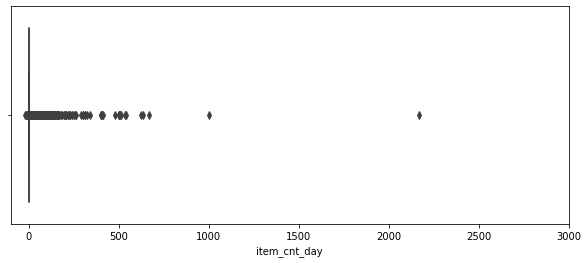

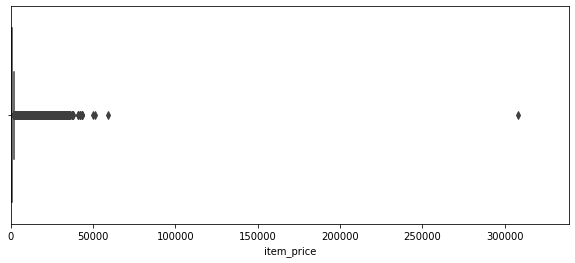

In [11]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [12]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [13]:
train.loc[train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [14]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median
train.loc[train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [15]:
# Shops with same name needs to be add together
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11



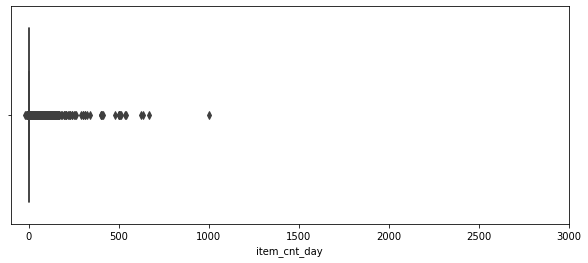

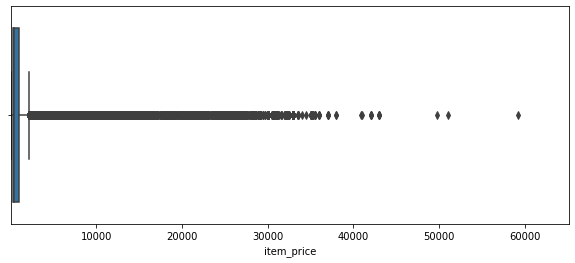

In [16]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [17]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [18]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00
...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,299.00
2935845,09.10.2015,33,25,7460,299.00,1.0,299.00
2935846,14.10.2015,33,25,7459,349.00,1.0,349.00
2935847,22.10.2015,33,25,7440,299.00,1.0,299.00


In [23]:
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)
group

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0
...,...,...,...,...
1609118,33,59,22087,6.0
1609119,33,59,22088,2.0
1609120,33,59,22091,1.0
1609121,33,59,22100,1.0


In [24]:
# matrix = pd.merge(matrix, group, on=cols, how='left')
# matrix['item_cnt_month'] = (matrix['item_cnt_month']
#                                 .fillna(0)
#                                 .clip(0,20) # NB clip target here
#                                 .astype(np.float16))
matrix = group
matrix

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0
...,...,...,...,...
1609118,33,59,22087,6.0
1609119,33,59,22088,2.0
1609120,33,59,22091,1.0
1609121,33,59,22100,1.0


In [25]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_name,item_category_id,type_code,subtype_code
0,0,2,27,1.0,0,"007 Legends [PS3, русская версия]",19,6,32
1,0,2,33,1.0,0,1+1 (BD),37,9,6
2,0,2,317,1.0,0,1С:Аудиокниги. Мединский В. Мифы о России. О р...,45,2,4
3,0,2,438,1.0,0,1С:Аудиотеатр. Лучшие произведения русских пис...,45,2,4
4,0,2,471,2.0,0,1С:Бухгалтерия 8 (ред.3.0) как на ладони. Изд ...,49,2,28
...,...,...,...,...,...,...,...,...,...
1609118,33,59,22087,6.0,29,Элемент питания DURACELL LR03-BC2,83,19,45
1609119,33,59,22088,2.0,29,Элемент питания DURACELL LR06-BC2,83,19,45
1609120,33,59,22091,1.0,29,Элемент питания DURACELL TURBO LR 03 2*BL,83,19,45
1609121,33,59,22100,1.0,29,Энциклопедия Adventure Time,42,2,44


In [26]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df



In [27]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
# matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_name,item_category_id,type_code,subtype_code,date_item_avg_item_cnt
0,0,2,27,1.0,0,"007 Legends [PS3, русская версия]",19,6,32,1.000000
1,0,2,33,1.0,0,1+1 (BD),37,9,6,2.033203
2,0,2,317,1.0,0,1С:Аудиокниги. Мединский В. Мифы о России. О р...,45,2,4,1.000000
3,0,2,438,1.0,0,1С:Аудиотеатр. Лучшие произведения русских пис...,45,2,4,1.000000
4,0,2,471,2.0,0,1С:Бухгалтерия 8 (ред.3.0) как на ладони. Изд ...,49,2,28,2.214844
...,...,...,...,...,...,...,...,...,...,...
1609118,33,59,22087,6.0,29,Элемент питания DURACELL LR03-BC2,83,19,45,3.345703
1609119,33,59,22088,2.0,29,Элемент питания DURACELL LR06-BC2,83,19,45,5.441406
1609120,33,59,22091,1.0,29,Элемент питания DURACELL TURBO LR 03 2*BL,83,19,45,1.500000
1609121,33,59,22100,1.0,29,Энциклопедия Adventure Time,42,2,44,4.789062


In [28]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_name,item_category_id,type_code,subtype_code,date_item_avg_item_cnt,date_avg_item_cnt
0,0,2,27,1.0,0,"007 Legends [PS3, русская версия]",19,6,32,1.000000,2.080078
1,0,2,33,1.0,0,1+1 (BD),37,9,6,2.033203,2.080078
2,0,2,317,1.0,0,1С:Аудиокниги. Мединский В. Мифы о России. О р...,45,2,4,1.000000,2.080078
3,0,2,438,1.0,0,1С:Аудиотеатр. Лучшие произведения русских пис...,45,2,4,1.000000,2.080078
4,0,2,471,2.0,0,1С:Бухгалтерия 8 (ред.3.0) как на ладони. Изд ...,49,2,28,2.214844,2.080078
...,...,...,...,...,...,...,...,...,...,...,...
1609118,33,59,22087,6.0,29,Элемент питания DURACELL LR03-BC2,83,19,45,3.345703,2.185547
1609119,33,59,22088,2.0,29,Элемент питания DURACELL LR06-BC2,83,19,45,5.441406,2.185547
1609120,33,59,22091,1.0,29,Элемент питания DURACELL TURBO LR 03 2*BL,83,19,45,1.500000,2.185547
1609121,33,59,22100,1.0,29,Энциклопедия Adventure Time,42,2,44,4.789062,2.185547


In [29]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_name,item_category_id,type_code,subtype_code,date_item_avg_item_cnt,date_avg_item_cnt,date_shop_avg_item_cnt
0,0,2,27,1.0,0,"007 Legends [PS3, русская версия]",19,6,32,1.000000,2.080078,1.574219
1,0,2,33,1.0,0,1+1 (BD),37,9,6,2.033203,2.080078,1.574219
2,0,2,317,1.0,0,1С:Аудиокниги. Мединский В. Мифы о России. О р...,45,2,4,1.000000,2.080078,1.574219
3,0,2,438,1.0,0,1С:Аудиотеатр. Лучшие произведения русских пис...,45,2,4,1.000000,2.080078,1.574219
4,0,2,471,2.0,0,1С:Бухгалтерия 8 (ред.3.0) как на ладони. Изд ...,49,2,28,2.214844,2.080078,1.574219
...,...,...,...,...,...,...,...,...,...,...,...,...
1609118,33,59,22087,6.0,29,Элемент питания DURACELL LR03-BC2,83,19,45,3.345703,2.185547,1.580078
1609119,33,59,22088,2.0,29,Элемент питания DURACELL LR06-BC2,83,19,45,5.441406,2.185547,1.580078
1609120,33,59,22091,1.0,29,Элемент питания DURACELL TURBO LR 03 2*BL,83,19,45,1.500000,2.185547,1.580078
1609121,33,59,22100,1.0,29,Энциклопедия Adventure Time,42,2,44,4.789062,2.185547,1.580078


In [30]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_name,item_category_id,type_code,subtype_code,date_item_avg_item_cnt,date_avg_item_cnt,date_shop_avg_item_cnt,date_cat_avg_item_cnt
0,0,2,27,1.0,0,"007 Legends [PS3, русская версия]",19,6,32,1.000000,2.080078,1.574219,2.656250
1,0,2,33,1.0,0,1+1 (BD),37,9,6,2.033203,2.080078,1.574219,1.448242
2,0,2,317,1.0,0,1С:Аудиокниги. Мединский В. Мифы о России. О р...,45,2,4,1.000000,2.080078,1.574219,1.219727
3,0,2,438,1.0,0,1С:Аудиотеатр. Лучшие произведения русских пис...,45,2,4,1.000000,2.080078,1.574219,1.219727
4,0,2,471,2.0,0,1С:Бухгалтерия 8 (ред.3.0) как на ладони. Изд ...,49,2,28,2.214844,2.080078,1.574219,2.109375
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609118,33,59,22087,6.0,29,Элемент питания DURACELL LR03-BC2,83,19,45,3.345703,2.185547,1.580078,3.412109
1609119,33,59,22088,2.0,29,Элемент питания DURACELL LR06-BC2,83,19,45,5.441406,2.185547,1.580078,3.412109
1609120,33,59,22091,1.0,29,Элемент питания DURACELL TURBO LR 03 2*BL,83,19,45,1.500000,2.185547,1.580078,3.412109
1609121,33,59,22100,1.0,29,Энциклопедия Adventure Time,42,2,44,4.789062,2.185547,1.580078,3.751953


In [31]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_name,item_category_id,type_code,subtype_code,date_item_avg_item_cnt,date_avg_item_cnt,date_shop_avg_item_cnt,date_cat_avg_item_cnt,date_shop_cat_avg_item_cnt
0,0,2,27,1.0,0,"007 Legends [PS3, русская версия]",19,6,32,1.000000,2.080078,1.574219,2.656250,1.900391
1,0,2,33,1.0,0,1+1 (BD),37,9,6,2.033203,2.080078,1.574219,1.448242,1.040039
2,0,2,317,1.0,0,1С:Аудиокниги. Мединский В. Мифы о России. О р...,45,2,4,1.000000,2.080078,1.574219,1.219727,1.000000
3,0,2,438,1.0,0,1С:Аудиотеатр. Лучшие произведения русских пис...,45,2,4,1.000000,2.080078,1.574219,1.219727,1.000000
4,0,2,471,2.0,0,1С:Бухгалтерия 8 (ред.3.0) как на ладони. Изд ...,49,2,28,2.214844,2.080078,1.574219,2.109375,1.142578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609118,33,59,22087,6.0,29,Элемент питания DURACELL LR03-BC2,83,19,45,3.345703,2.185547,1.580078,3.412109,3.000000
1609119,33,59,22088,2.0,29,Элемент питания DURACELL LR06-BC2,83,19,45,5.441406,2.185547,1.580078,3.412109,3.000000
1609120,33,59,22091,1.0,29,Элемент питания DURACELL TURBO LR 03 2*BL,83,19,45,1.500000,2.185547,1.580078,3.412109,3.000000
1609121,33,59,22100,1.0,29,Энциклопедия Adventure Time,42,2,44,4.789062,2.185547,1.580078,3.751953,1.000000


In [32]:
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)

In [33]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)

In [34]:
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)

In [35]:
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)

In [36]:
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)

In [37]:
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)

In [38]:
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

In [39]:
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

In [40]:
matrix['month'] = matrix['date_block_num'] % 12 + 1

In [41]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [42]:
matrix['year'] = matrix['date_block_num'] // 12 + 1

In [45]:
# matrix.drop(['month','year'], axis = 1, inplace = True) 
# matrix.sample(5)

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_name,item_category_id,type_code,subtype_code,date_item_avg_item_cnt,date_avg_item_cnt,date_shop_avg_item_cnt,date_cat_avg_item_cnt,date_shop_cat_avg_item_cnt,date_shop_type_avg_item_cnt,date_shop_subtype_avg_item_cnt,date_city_avg_item_cnt,date_item_city_avg_item_cnt,date_type_avg_item_cnt,date_subtype_avg_item_cnt,item_avg_item_price,date_item_avg_item_price,date_shop_revenue,shop_avg_revenue,days
531326,9,19,16130,1.0,10,Настольная игра Колонизаторы Быстрая карточная...,65,7,21,1.384766,2.496094,2.130859,3.802734,2.300781,2.597656,2.300781,2.130859,1.000000,3.578125,3.802734,398.75,399.00,2.114422e+06,1910409.500,31
832965,14,56,3835,1.0,2,"Halo 4. Game of the Year Edition [Xbox 360, ру...",23,6,43,2.525391,2.339844,1.879883,2.408203,2.173828,2.496094,2.226562,1.879883,1.000000,3.046875,2.404297,1298.00,1279.00,1.571561e+06,1723703.000,31
477138,8,17,20293,1.0,9,ФОРСАЖ (1-6),41,3,11,2.500000,2.585938,1.851562,1.351562,1.071289,1.071289,1.071289,2.494141,1.000000,1.351562,1.351562,687.00,688.00,1.313427e+06,1389247.375,30
449058,7,45,2341,2.0,17,"Call of Juarez: Gunslinger [PC, Jewel, русские...",30,6,30,3.000000,2.160156,1.805664,4.062500,3.222656,2.312500,2.904297,1.676758,3.000000,3.011719,3.853516,420.50,447.25,1.037735e+06,1203670.500,31
93980,1,31,5735,2.0,11,"Patapon 3 (Essentials) [PSP, русская версия]",21,6,34,1.333008,2.136719,3.201172,2.294922,4.093750,6.312500,3.875000,2.373047,1.142578,3.126953,2.269531,461.00,516.50,7.033617e+06,6918147.500,28


In [46]:
# matrix['month'] = matrix['date_block_num'] % 12 + 1
# matrix['year'] = matrix['date_block_num'] // 12 + 1
# matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_name,item_category_id,type_code,subtype_code,date_item_avg_item_cnt,date_avg_item_cnt,date_shop_avg_item_cnt,date_cat_avg_item_cnt,date_shop_cat_avg_item_cnt,date_shop_type_avg_item_cnt,date_shop_subtype_avg_item_cnt,date_city_avg_item_cnt,date_item_city_avg_item_cnt,date_type_avg_item_cnt,date_subtype_avg_item_cnt,item_avg_item_price,date_item_avg_item_price,date_shop_revenue,shop_avg_revenue,days,month,year
0,0,2,27,1.0,0,"007 Legends [PS3, русская версия]",19,6,32,1.000000,2.080078,1.574219,2.656250,1.900391,1.912109,1.985352,1.574219,1.0,2.937500,2.638672,1461.0000,2324.0000,1085064.75,1295577.625,31,1,1
1,0,2,33,1.0,0,1+1 (BD),37,9,6,2.033203,2.080078,1.574219,1.448242,1.040039,1.061523,1.061523,1.574219,1.0,1.429688,1.429688,252.8750,488.5000,1085064.75,1295577.625,31,1,1
2,0,2,317,1.0,0,1С:Аудиокниги. Мединский В. Мифы о России. О р...,45,2,4,1.000000,2.080078,1.574219,1.219727,1.000000,1.038086,1.000000,1.574219,1.0,1.393555,1.171875,291.0000,299.0000,1085064.75,1295577.625,31,1,1
3,0,2,438,1.0,0,1С:Аудиотеатр. Лучшие произведения русских пис...,45,2,4,1.000000,2.080078,1.574219,1.219727,1.000000,1.038086,1.000000,1.574219,1.0,1.393555,1.171875,290.7500,271.5000,1085064.75,1295577.625,31,1,1
4,0,2,471,2.0,0,1С:Бухгалтерия 8 (ред.3.0) как на ладони. Изд ...,49,2,28,2.214844,2.080078,1.574219,2.109375,1.142578,1.038086,1.142578,1.574219,2.0,1.393555,2.109375,397.0000,399.0000,1085064.75,1295577.625,31,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609118,33,59,22087,6.0,29,Элемент питания DURACELL LR03-BC2,83,19,45,3.345703,2.185547,1.580078,3.412109,3.000000,3.000000,3.000000,1.580078,6.0,3.412109,3.412109,88.0625,119.0000,972717.00,1330193.500,31,10,3
1609119,33,59,22088,2.0,29,Элемент питания DURACELL LR06-BC2,83,19,45,5.441406,2.185547,1.580078,3.412109,3.000000,3.000000,3.000000,1.580078,2.0,3.412109,3.412109,91.7500,118.5625,972717.00,1330193.500,31,10,3
1609120,33,59,22091,1.0,29,Элемент питания DURACELL TURBO LR 03 2*BL,83,19,45,1.500000,2.185547,1.580078,3.412109,3.000000,3.000000,3.000000,1.580078,1.0,3.412109,3.412109,128.1250,176.3750,972717.00,1330193.500,31,10,3
1609121,33,59,22100,1.0,29,Энциклопедия Adventure Time,42,2,44,4.789062,2.185547,1.580078,3.751953,1.000000,1.000000,1.000000,1.580078,1.0,2.728516,3.751953,627.5000,629.0000,972717.00,1330193.500,31,10,3


In [47]:
def fill_na(df):
    for col in df.columns:
        if df[col].isnull().any():
            df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_name,item_category_id,type_code,subtype_code,date_item_avg_item_cnt,date_avg_item_cnt,date_shop_avg_item_cnt,date_cat_avg_item_cnt,date_shop_cat_avg_item_cnt,date_shop_type_avg_item_cnt,date_shop_subtype_avg_item_cnt,date_city_avg_item_cnt,date_item_city_avg_item_cnt,date_type_avg_item_cnt,date_subtype_avg_item_cnt,item_avg_item_price,date_item_avg_item_price,date_shop_revenue,shop_avg_revenue,days,month,year
0,0,2,27,1.0,0,"007 Legends [PS3, русская версия]",19,6,32,1.000000,2.080078,1.574219,2.656250,1.900391,1.912109,1.985352,1.574219,1.0,2.937500,2.638672,1461.0000,2324.0000,1085064.75,1295577.625,31,1,1
1,0,2,33,1.0,0,1+1 (BD),37,9,6,2.033203,2.080078,1.574219,1.448242,1.040039,1.061523,1.061523,1.574219,1.0,1.429688,1.429688,252.8750,488.5000,1085064.75,1295577.625,31,1,1
2,0,2,317,1.0,0,1С:Аудиокниги. Мединский В. Мифы о России. О р...,45,2,4,1.000000,2.080078,1.574219,1.219727,1.000000,1.038086,1.000000,1.574219,1.0,1.393555,1.171875,291.0000,299.0000,1085064.75,1295577.625,31,1,1
3,0,2,438,1.0,0,1С:Аудиотеатр. Лучшие произведения русских пис...,45,2,4,1.000000,2.080078,1.574219,1.219727,1.000000,1.038086,1.000000,1.574219,1.0,1.393555,1.171875,290.7500,271.5000,1085064.75,1295577.625,31,1,1
4,0,2,471,2.0,0,1С:Бухгалтерия 8 (ред.3.0) как на ладони. Изд ...,49,2,28,2.214844,2.080078,1.574219,2.109375,1.142578,1.038086,1.142578,1.574219,2.0,1.393555,2.109375,397.0000,399.0000,1085064.75,1295577.625,31,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609118,33,59,22087,6.0,29,Элемент питания DURACELL LR03-BC2,83,19,45,3.345703,2.185547,1.580078,3.412109,3.000000,3.000000,3.000000,1.580078,6.0,3.412109,3.412109,88.0625,119.0000,972717.00,1330193.500,31,10,3
1609119,33,59,22088,2.0,29,Элемент питания DURACELL LR06-BC2,83,19,45,5.441406,2.185547,1.580078,3.412109,3.000000,3.000000,3.000000,1.580078,2.0,3.412109,3.412109,91.7500,118.5625,972717.00,1330193.500,31,10,3
1609120,33,59,22091,1.0,29,Элемент питания DURACELL TURBO LR 03 2*BL,83,19,45,1.500000,2.185547,1.580078,3.412109,3.000000,3.000000,3.000000,1.580078,1.0,3.412109,3.412109,128.1250,176.3750,972717.00,1330193.500,31,10,3
1609121,33,59,22100,1.0,29,Энциклопедия Adventure Time,42,2,44,4.789062,2.185547,1.580078,3.751953,1.000000,1.000000,1.000000,1.580078,1.0,2.728516,3.751953,627.5000,629.0000,972717.00,1330193.500,31,10,3


In [48]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609123 entries, 0 to 1609122
Data columns (total 27 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   date_block_num                  1609123 non-null  int64  
 1   shop_id                         1609123 non-null  int64  
 2   item_id                         1609123 non-null  int64  
 3   item_cnt_month                  1609123 non-null  float64
 4   city_code                       1609123 non-null  int8   
 5   item_name                       1609123 non-null  object 
 6   item_category_id                1609123 non-null  int8   
 7   type_code                       1609123 non-null  int8   
 8   subtype_code                    1609123 non-null  int8   
 9   date_item_avg_item_cnt          1609123 non-null  float16
 10  date_avg_item_cnt               1609123 non-null  float16
 11  date_shop_avg_item_cnt          1609123 non-null  float16
 12  

In [147]:
corrmat = matrix.corr()
top_corr_features = corrmat.index



NameError: name 'data' is not defined

<Figure size 1440x1440 with 0 Axes>

In [149]:
top_corr_features

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code',
       'date_item_avg_item_cnt', 'date_avg_item_cnt', 'date_shop_avg_item_cnt',
       'date_cat_avg_item_cnt', 'date_shop_cat_avg_item_cnt_x',
       'date_shop_cat_avg_item_cnt_y', 'date_shop_type_avg_item_cnt',
       'date_shop_subtype_avg_item_cnt', 'date_city_avg_item_cnt',
       'date_item_city_avg_item_cnt', 'date_type_avg_item_cnt',
       'date_subtype_avg_item_cnt', 'item_avg_item_price',
       'date_item_avg_item_price', 'date_shop_revenue', 'shop_avg_revenue',
       'month', 'days'],
      dtype='object')

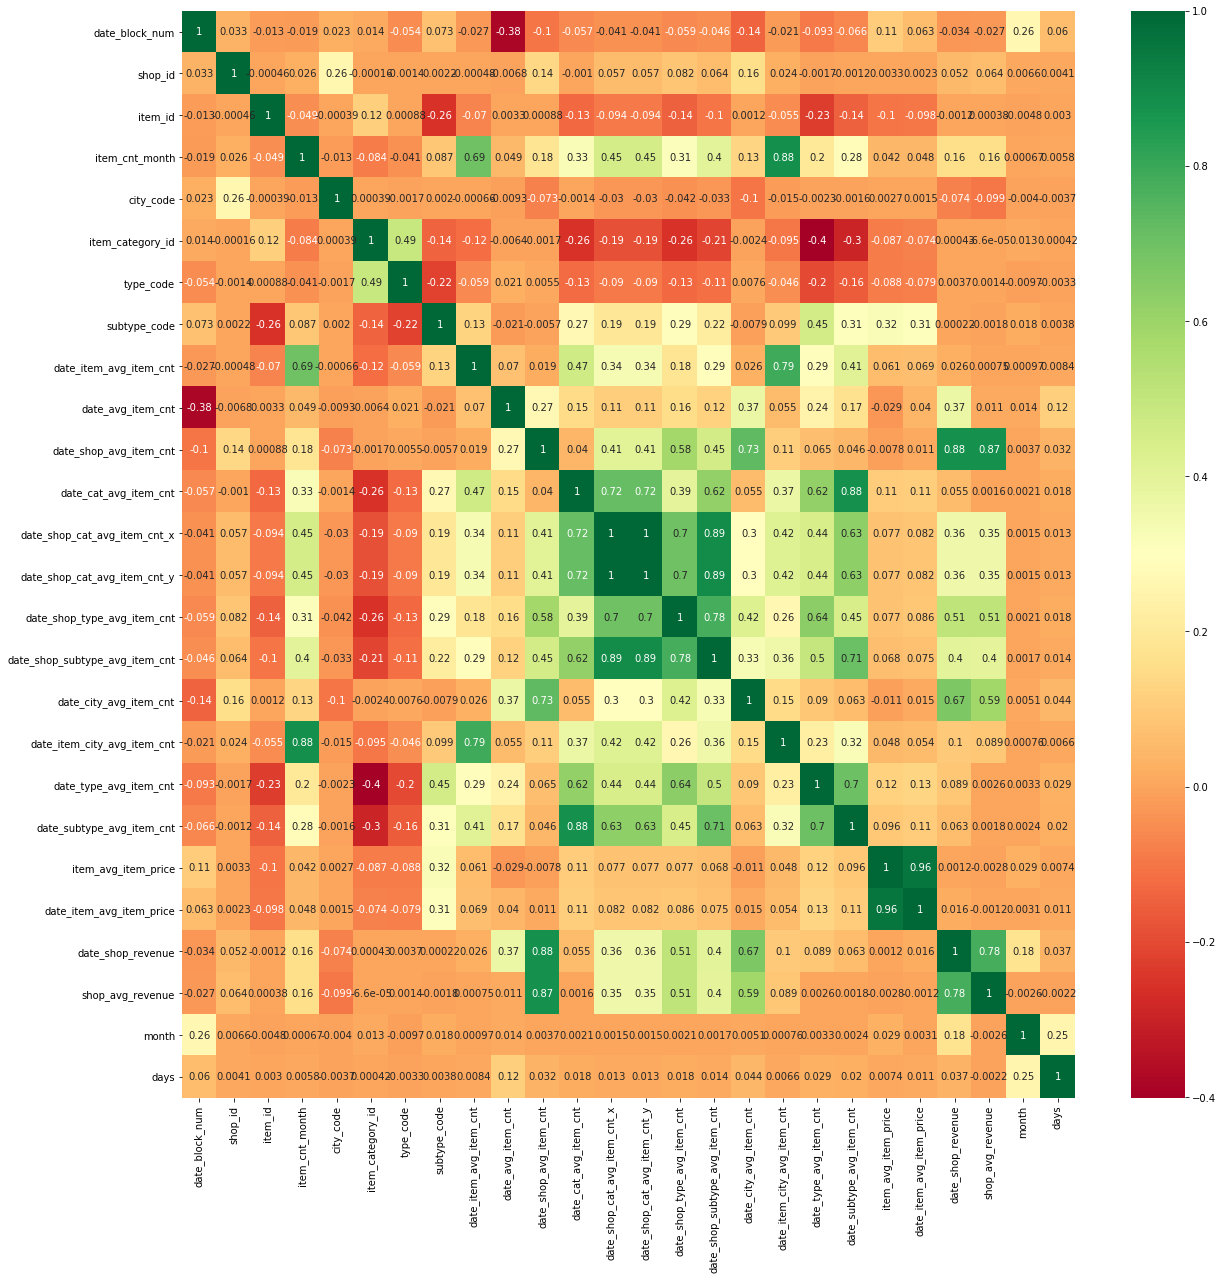

In [150]:
#plot heat map
# plt.figure(figsize=(200,200))
plt.subplots(figsize=(20,20))
g=sns.heatmap(matrix[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [49]:
item_cnt = matrix['item_cnt_month']
matrix.drop(labels=['item_cnt_month'], axis=1, inplace = True)
matrix.insert(26, 'item_cnt_month', item_cnt)

In [52]:

matrix.sample(5)

,date_block_num,shop_id,item_id,city_code,item_name,item_category_id,type_code,subtype_code,date_item_avg_item_cnt,date_avg_item_cnt,date_shop_avg_item_cnt,date_cat_avg_item_cnt,date_shop_cat_avg_item_cnt,date_shop_type_avg_item_cnt,date_shop_subtype_avg_item_cnt,date_city_avg_item_cnt,date_item_city_avg_item_cnt,date_type_avg_item_cnt,date_subtype_avg_item_cnt,item_avg_item_price,date_item_avg_item_price,date_shop_revenue,shop_avg_revenue,days,month,year,item_cnt_month
770764,13,42,385,20,1С:Аудиокниги. Твен М. Приключения Тома Сойера,45,2,4,1.750000,2.298828,2.314453,1.126953,1.000000,1.243164,1.090820,2.308594,1.0,1.735352,1.212891,248.000,249.0000,3860708.000,4.468148e+06,28,2,2,1.0
423065,7,19,14527,10,МЕЛЬНИЦА Ангелофрения (фирм.),55,10,9,1.286133,2.160156,2.039062,1.445312,1.224609,1.211914,1.214844,2.039062,2.0,1.417969,1.437500,275.500,299.0000,1546565.500,1.910410e+06,31,8,1,2.0
224698,3,44,6753,17,"Street Fighter X Tekken [PS3, русские субтитры]",19,6,32,1.000000,1.961914,1.534180,2.275391,1.613281,1.924805,1.582031,1.585938,1.0,2.660156,2.205078,960.000,899.0000,845157.000,1.006001e+06,30,4,1,1.0
907218,16,35,3380,13,FLY PROJECT Hits From 2005 To 2013,55,10,9,1.000000,2.136719,1.958984,1.391602,1.433594,1.423828,1.432617,1.958984,1.0,1.369141,1.384766,180.625,84.6875,1961824.875,2.064846e+06,31,5,2,1.0
1136725,21,44,8672,17,БАРБОСКИНЫ ВЫПУСК 8: САМЫЙ ЛУЧШИЙ ДЕД (регион),40,8,14,1.500000,2.521484,1.737305,1.814453,1.508789,1.502930,1.508789,1.839844,2.0,1.811523,1.814453,156.125,149.0000,1068723.000,1.006001e+06,31,10,2,2.0


In [53]:
matrix.to_pickle('training_data_v2.pkl')

In [45]:
matrix.drop(labels=['date_item_city_avg_item_cnt_y'], axis=1, inplace = True)
matrix.rename(columns = {'date_item_city_avg_item_cnt_x':'date_item_city_avg_item_cnt'}, inplace = True)
matrix.drop(labels=['item_name','type_code','subtype_code','date_shop_type_avg_item_cnt','date_shop_subtype_avg_item_cnt','date_type_avg_item_cnt','date_subtype_avg_item_cnt'], axis=1, inplace = True)
matrix

,date_block_num,shop_id,item_id,city_code,item_category_id,date_item_avg_item_cnt,date_avg_item_cnt,date_shop_avg_item_cnt,date_cat_avg_item_cnt,date_shop_cat_avg_item_cnt,date_city_avg_item_cnt,date_item_city_avg_item_cnt,item_avg_item_price,date_item_avg_item_price,date_shop_revenue,shop_avg_revenue,days,month,year,item_cnt_month
0,0,0,32,28,40,8.078125,2.080078,2.337891,1.865234,2.207031,2.173828,6.5,249.6250,338.0000,2966412.0,3318685.0,31,1,1,6.0
1,0,0,33,28,37,2.033203,2.080078,2.337891,1.448242,1.445312,2.173828,3.0,252.8750,488.5000,2966412.0,3318685.0,31,1,1,3.0
2,0,0,35,28,40,3.250000,2.080078,2.337891,1.865234,2.207031,2.173828,1.0,375.7500,390.7500,2966412.0,3318685.0,31,1,1,1.0
3,0,0,43,28,40,1.000000,2.080078,2.337891,1.865234,2.207031,2.173828,1.0,167.2500,234.5000,2966412.0,3318685.0,31,1,1,1.0
4,0,0,51,28,57,1.625000,2.080078,2.337891,1.293945,1.176758,2.173828,2.0,265.7500,230.5000,2966412.0,3318685.0,31,1,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609118,33,59,22087,29,83,3.345703,2.185547,1.580078,3.412109,3.000000,1.580078,6.0,88.0625,119.0000,972717.0,1330193.5,31,10,3,6.0
1609119,33,59,22088,29,83,5.441406,2.185547,1.580078,3.412109,3.000000,1.580078,2.0,91.7500,118.5625,972717.0,1330193.5,31,10,3,2.0
1609120,33,59,22091,29,83,1.500000,2.185547,1.580078,3.412109,3.000000,1.580078,1.0,128.1250,176.3750,972717.0,1330193.5,31,10,3,1.0
1609121,33,59,22100,29,42,4.789062,2.185547,1.580078,3.751953,1.000000,1.580078,1.0,627.5000,629.0000,972717.0,1330193.5,31,10,3,1.0


In [55]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609123 entries, 0 to 1609122
Data columns (total 27 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   date_block_num                  1609123 non-null  int64  
 1   shop_id                         1609123 non-null  int64  
 2   item_id                         1609123 non-null  int64  
 3   city_code                       1609123 non-null  int8   
 4   item_name                       1609123 non-null  object 
 5   item_category_id                1609123 non-null  int8   
 6   type_code                       1609123 non-null  int8   
 7   subtype_code                    1609123 non-null  int8   
 8   date_item_avg_item_cnt          1609123 non-null  float16
 9   date_avg_item_cnt               1609123 non-null  float16
 10  date_shop_avg_item_cnt          1609123 non-null  float16
 11  date_cat_avg_item_cnt           1609123 non-null  float16
 12  

In [46]:
matrix.to_pickle('training_data.pkl')

In [44]:
matrix.fillna(0)

,date_block_num,shop_id,item_id,city_code,item_name,item_category_id,type_code,subtype_code,date_item_avg_item_cnt,date_avg_item_cnt,date_shop_avg_item_cnt,date_cat_avg_item_cnt,date_shop_cat_avg_item_cnt,date_city_avg_item_cnt,date_item_city_avg_item_cnt_x,date_shop_type_avg_item_cnt,date_shop_subtype_avg_item_cnt,date_item_city_avg_item_cnt_y,date_type_avg_item_cnt,date_subtype_avg_item_cnt,item_avg_item_price,date_item_avg_item_price,date_shop_revenue,shop_avg_revenue,days,month,year,item_cnt_month
0,0,0,32,28,1+1,40,8,14,8.078125,2.080078,2.337891,1.865234,2.207031,2.173828,6.5,2.207031,2.207031,6.5,1.865234,1.865234,249.6250,338.0000,2966412.0,3318685.0,31,1,1,6.0
1,0,0,33,28,1+1 (BD),37,9,6,2.033203,2.080078,2.337891,1.448242,1.445312,2.173828,3.0,1.418945,1.418945,3.0,1.429688,1.429688,252.8750,488.5000,2966412.0,3318685.0,31,1,1,3.0
2,0,0,35,28,10 ЛЕТ СПУСТЯ,40,8,14,3.250000,2.080078,2.337891,1.865234,2.207031,2.173828,1.0,2.207031,2.207031,1.0,1.865234,1.865234,375.7500,390.7500,2966412.0,3318685.0,31,1,1,1.0
3,0,0,43,28,100 МИЛЛИОНОВ ЕВРО,40,8,14,1.000000,2.080078,2.337891,1.865234,2.207031,2.173828,1.0,2.207031,2.207031,1.0,1.865234,1.865234,167.2500,234.5000,2966412.0,3318685.0,31,1,1,1.0
4,0,0,51,28,100 лучших произведений классики (mp3-CD) (Dig...,57,10,27,1.625000,2.080078,2.337891,1.293945,1.176758,2.173828,2.0,1.269531,1.176758,2.0,1.342773,1.293945,265.7500,230.5000,2966412.0,3318685.0,31,1,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609118,33,59,22087,29,Элемент питания DURACELL LR03-BC2,83,19,45,3.345703,2.185547,1.580078,3.412109,3.000000,1.580078,6.0,3.000000,3.000000,6.0,3.412109,3.412109,88.0625,119.0000,972717.0,1330193.5,31,10,3,6.0
1609119,33,59,22088,29,Элемент питания DURACELL LR06-BC2,83,19,45,5.441406,2.185547,1.580078,3.412109,3.000000,1.580078,2.0,3.000000,3.000000,2.0,3.412109,3.412109,91.7500,118.5625,972717.0,1330193.5,31,10,3,2.0
1609120,33,59,22091,29,Элемент питания DURACELL TURBO LR 03 2*BL,83,19,45,1.500000,2.185547,1.580078,3.412109,3.000000,1.580078,1.0,3.000000,3.000000,1.0,3.412109,3.412109,128.1250,176.3750,972717.0,1330193.5,31,10,3,1.0
1609121,33,59,22100,29,Энциклопедия Adventure Time,42,2,44,4.789062,2.185547,1.580078,3.751953,1.000000,1.580078,1.0,1.000000,1.000000,1.0,2.728516,3.751953,627.5000,629.0000,972717.0,1330193.5,31,10,3,1.0


In [167]:
matrix.to_pickle('data.pkl')

In [47]:
del matrix
del group
del items
del shops
del cats
del train
gc.collect()

14